In [1]:
from Tony_compression import *

%matplotlib widget
import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm

In [2]:
from typing import Tuple, NamedTuple, Optional

import numpy as np
from cued_sf2_lab.laplacian_pyramid import quant1, quant2
from cued_sf2_lab.dct import dct_ii, colxfm, regroup
from cued_sf2_lab.bitword import bitword

In [3]:
X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
X = X - 128.0

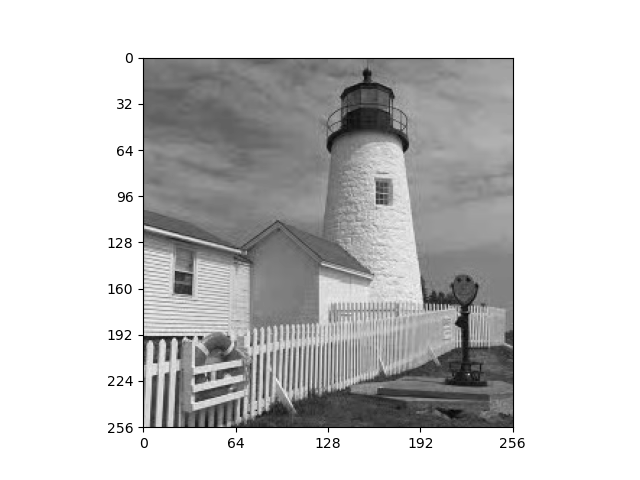

In [32]:
s = 1.31
N = 8
Y = lbt(X, N=N, s=s, step=17, k=0.5)
bit_req = 80000
Yq = equal_bit_quantise(Y, bit_req)
Z = ilbt(Yq,N = N, s = s)
fig, ax = plt.subplots()
plot_image(Z, ax=ax)


In [33]:
bpp(Yq) * Yq.size

80000.34256303175

In [34]:
np.std(Z - X)

5.193598258610815

In [35]:
from cued_sf2_lab.jpeg import (
    jpegenc, jpegdec, quant1, quant2, huffenc, huffdflt, huffdes, huffgen)

In [ ]:
M = 8
N = 8
huffhist = np.zeros(16 ** 2)
vlc = []
for r in range(0, sy[0], M):
    for c in range(0, sy[1], M):
        yq = Yq[r:r+M, c:c+M]
        # Possibly regroup
        if M > N:
            yq = regroup(yq, N)
        yqflat = yq.flatten('F')
        # Encode DC coefficient first
        dccoef = yqflat[0] + 2 ** (dcbits-1)
        vlc.append(np.array([[dccoef, dcbits]]))
        # Encode the other AC coefficients in scan order
        # huffenc() also updates huffhist.
        ra1 = runampl(yqflat[scan])
        vlc.append(huffenc(huffhist, ra1, ehuf))
# (0, 2) array makes this work even if `vlc == []`
vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

In [ ]:
dhufftab = huffdflt(1)
huffcode, ehuf = huffgen(dhufftab)

In [52]:
def diagscan(N: int) -> np.ndarray:
    '''
    Generate diagonal scanning pattern

    Returns:
        A diagonal scanning index for a flattened NxN matrix

        The first entry in the matrix is assumed to be the DC coefficient
        and is therefore not included in the scan
    '''
    if N <= 1:
        raise ValueError('Cannot generate a scan pattern for a {}x{} matrix'.format(N, N))

    # Copied from matlab without accounting for indexing.
    slast = N + 1
    scan = [slast]
    while slast != N * N:
        while slast > N and slast % N != 0:
            slast = slast - (N - 1)
            scan.append(slast)
        if slast < N:
            slast = slast + 1
        else:
            slast = slast + N
        scan.append(slast)
        if slast == N * N:
            break
        while slast < (N * N - N + 1) and slast % N != 1:
            slast = slast + (N - 1)
            scan.append(slast)
        if slast == N * N:
            break
        if slast < (N * N - N + 1):
            slast = slast + N
        else:
            slast = slast + 1
        scan.append(slast)
    # Python indexing
    return np.array(scan) - 1

In [55]:
def runampl(a: np.ndarray) -> np.ndarray:
    '''
    Create a run-amplitude encoding from input stream of integers

    Parameters:
        a: array of integers to encode

    Returns:
        ra: (N, 3) array
            ``ra[:, 0]`` gives the runs of zeros between each non-zero value.
            ``ra[:, 1]`` gives the JPEG sizes of the non-zero values (no of
            bits excluding leading zeros).
            ``ra[:, 2]`` gives the values of the JPEG remainder, which
            is normally coded in offset binary.
    '''
    # Check for non integer values in a
    if not np.issubdtype(a.dtype, np.integer):
        raise TypeError(f"Arguments to runampl must be integers, got {a.dtype}")
    b = np.where(a != 0)[0]
    if len(b) == 0:
        ra = np.array([[0, 0, 0]])
        return ra

    # List non-zero elements as a column vector
    c = a[b]
    # Generate JPEG size vector ca = floor(log2(abs(c)) + 1)
    ca = np.zeros(c.shape, dtype=np.int64)
    k = 1
    cb = np.abs(c)
    maxc = np.max(cb)

    ka = [1]
    while k <= maxc:
        ca += (cb >= k)
        k = k * 2
        ka.append(k)
    ka = np.array(ka)

    cneg = np.where(c < 0)[0]
    # Changes expression for python indexing
    c[cneg] = c[cneg] + ka[ca[cneg]] - 1
    # appended -1 instead of 0.
    col1 = np.diff(np.concatenate((np.array([-1]), b))) - 1
    ra = np.stack((col1, ca, c), axis=1)
    ra = np.concatenate((ra, np.array([[0, 0, 0]])))
    return ra

In [60]:
def Jtechenc(X: np.ndarray, bits: float, N: int = 8, M: int = 8,
        opthuff: bool = False, dcbits: int = 8, log: bool = True
        ):

    if M % N != 0:
            raise ValueError('M must be an integer multiple of N!')

    # DCT on input image X.
    if log:
        print('Forward {} x {} DCT'.format(N, N))
    C8 = dct_ii(N)
    #Y = colxfm(colxfm(X, C8).T, C8).T
    Y = lbt(X,N,s = 1.31)

    def objective1(qstep):
        Yq = quant1(Y, qstep, qstep).astype('int')
        return np.abs(bpp(Yq) * Yq.size - bits)

    result = minimize(objective1, 10, method='Nelder-Mead')
    qstep = result.x[0]

    # Quantise to integers.
    if log:
        print('Quantising to step size of {}'.format(qstep))
    Yq = quant1(Y, qstep, qstep).astype('int')

    # Generate zig-zag scan of AC coefs.
    scan = diagscan(M)

    # On the first pass use default huffman tables.
    if log:
        print('Generating huffcode and ehuf using default tables')
    dhufftab = huffdflt(1)  # Default tables.
    huffcode, ehuf = huffgen(dhufftab)

    # Generate run/ampl values and code them into vlc(:,1:2).
    # Also generate a histogram of code symbols.
    if log:
        print('Coding rows')
    sy = Yq.shape
    huffhist = np.zeros(16 ** 2)
    vlc = []
    for r in range(0, sy[0], M):
        for c in range(0, sy[1], M):
            yq = Yq[r:r+M,c:c+M]
            # Possibly regroup
            if M > N:
                yq = regroup(yq, N)
            yqflat = yq.flatten('F')
            # Encode DC coefficient first
            dccoef = yqflat[0] + 2 ** (dcbits-1)
            if dccoef not in range(2**dcbits):
                raise ValueError(
                    'DC coefficients too large for desired number of bits')
            vlc.append(np.array([[dccoef, dcbits]]))
            # Encode the other AC coefficients in scan order
            # huffenc() also updates huffhist.
            ra1 = runampl(yqflat[scan])
            vlc.append(huffenc(huffhist, ra1, ehuf))
    # (0, 2) array makes this work even if `vlc == []`
    vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

    # Return here if the default tables are sufficient, otherwise repeat the
    # encoding process using the custom designed huffman tables.
    if not opthuff:
        if log:
            print('Bits for coded image = {}'.format(sum(vlc[:, 1])))
        return vlc, dhufftab

# Design custom huffman tables.
    if log:
        print('Generating huffcode and ehuf using custom tables')
    dhufftab = huffdes(huffhist)
    huffcode, ehuf = huffgen(dhufftab)

    # Generate run/ampl values and code them into vlc(:,1:2).
    # Also generate a histogram of code symbols.
    if log:
        print('Coding rows (second pass)')
    huffhist = np.zeros(16 ** 2)
    vlc = []
    for r in range(0, sy[0], M):
        for c in range(0, sy[1], M):
            yq = Yq[r:r+M, c:c+M]
            # Possibly regroup
            if M > N:
                yq = regroup(yq, N)
            yqflat = yq.flatten('F')
            # Encode DC coefficient first
            dccoef = yqflat[0] + 2 ** (dcbits-1)
            vlc.append(np.array([[dccoef, dcbits]]))
            # Encode the other AC coefficients in scan order
            # huffenc() also updates huffhist.
            ra1 = runampl(yqflat[scan])
            vlc.append(huffenc(huffhist, ra1, ehuf))
    # (0, 2) array makes this work even if `vlc == []`
    vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

    if log:
        print('Bits for coded image = {}'.format(sum(vlc[:, 1])))
        print('Bits for huffman table = {}'.format(
            (16 + max(dhufftab.huffval.shape))*8))

    return vlc, dhufftab,qstep

In [61]:
vlc,hufftab,qstep = Jtechenc(X,bits = 70000,opthuff = True)
dict(zip(hufftab.huffval, hufftab.codes))

Forward 8 x 8 DCT
Quantising to step size of 19.17333984375
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 58302
Bits for huffman table = 1424


{1: bitword(0b00, 2),
 0: bitword(0b010, 3),
 2: bitword(0b011, 3),
 3: bitword(0b1000, 4),
 17: bitword(0b1001, 4),
 4: bitword(0b10100, 5),
 18: bitword(0b10101, 5),
 33: bitword(0b10110, 5),
 49: bitword(0b10111, 5),
 19: bitword(0b110000, 6),
 34: bitword(0b110001, 6),
 50: bitword(0b110010, 6),
 65: bitword(0b110011, 6),
 81: bitword(0b110100, 6),
 97: bitword(0b110101, 6),
 113: bitword(0b110110, 6),
 129: bitword(0b110111, 6),
 5: bitword(0b1110000, 7),
 66: bitword(0b1110001, 7),
 82: bitword(0b1110010, 7),
 145: bitword(0b1110011, 7),
 161: bitword(0b1110100, 7),
 177: bitword(0b1110101, 7),
 193: bitword(0b1110110, 7),
 240: bitword(0b1110111, 7),
 20: bitword(0b11110000, 8),
 35: bitword(0b11110001, 8),
 51: bitword(0b11110010, 8),
 98: bitword(0b11110011, 8),
 114: bitword(0b11110100, 8),
 178: bitword(0b11110101, 8),
 209: bitword(0b11110110, 8),
 67: bitword(0b111101110, 9),
 99: bitword(0b111101111, 9),
 115: bitword(0b111110000, 9),
 130: bitword(0b111110001, 9),
 146: 

In [63]:
def jtechdec(vlc: np.ndarray, qstep: float, N: int = 8, M: int = 8,
        hufftab:Optional[HuffmanTable] = None,
        dcbits: int = 8, W: int = 256, H: int = 256, log: bool = True
        ):
    '''
    Decodes a (simplified) JPEG bit stream to an image

    Parameters:

        vlc: variable length output code from jpegenc
        qstep: quantisation step to use in decoding
        N: width of the DCT block (defaults to 8)
        M: width of each block to be coded (defaults to N). Must be an
            integer multiple of N - if it is larger, individual blocks are
            regrouped.
        hufftab: if supplied, these will be used in Huffman decoding
            of the data, otherwise default tables are used
        dcbits: the number of bits to use to decode the DC coefficients
            of the DCT
        W, H: the size of the image (defaults to 256 x 256)

    Returns:

        Z: the output greyscale image
    '''

    opthuff = (hufftab is not None)
    if M % N != 0:
        raise ValueError('M must be an integer multiple of N!')

    # Set up standard scan sequence
    scan = diagscan(M)

    if opthuff:
        if len(hufftab.bits.shape) != 1:
            raise ValueError('bits.shape must be (len(bits),)')
        if log:
            print('Generating huffcode and ehuf using custom tables')
    else:
        if log:
            print('Generating huffcode and ehuf using default tables')
        hufftab = huffdflt(1)
    # Define starting addresses of each new code length in huffcode.
    # 0-based indexing instead of 1
    huffstart = np.cumsum(np.block([0, hufftab.bits[:15]]))
    # Set up huffman coding arrays.
    huffcode, ehuf = huffgen(hufftab)

    # Define array of powers of 2 from 1 to 2^16.
    k = 2 ** np.arange(17)

    # For each block in the image:

    # Decode the dc coef (a fixed-length word)
    # Look for any 15/0 code words.
    # Choose alternate code words to be decoded (excluding 15/0 ones).
    # and mark these with vector t until the next 0/0 EOB code is found.
    # Decode all the t huffman codes, and the t+1 amplitude codes.

    eob = ehuf[0]
    run16 = ehuf[15 * 16]
    i = 0
    Zq = np.zeros((H, W))

    if log:
        print('Decoding rows')
    for r in range(0, H, M):
        for c in range(0, W, M):
            yq = np.zeros(M**2)

            # Decode DC coef - assume no of bits is correctly given in vlc table.
            cf = 0
            if vlc[i, 1] != dcbits:
                raise ValueError(
                    'The bits for the DC coefficient does not agree with vlc table')
            yq[cf] = vlc[i, 0] - 2 ** (dcbits-1)
            i += 1

            # Loop for each non-zero AC coef.
            while np.any(vlc[i] != eob):
                run = 0

                # Decode any runs of 16 zeros first.
                while np.all(vlc[i] == run16):
                    run += 16
                    i += 1

                # Decode run and size (in bits) of AC coef.
                start = huffstart[vlc[i, 1] - 1]
                res = hufftab.huffval[start + vlc[i, 0] - huffcode[start]]
                run += res // 16
                cf += run + 1
                si = res % 16
                i += 1

                # Decode amplitude of AC coef.
                if vlc[i, 1] != si:
                    raise ValueError(
                        'Problem with decoding .. you might be using the wrong hufftab table')
                ampl = vlc[i, 0]

                # Adjust ampl for negative coef (i.e. MSB = 0).
                thr = k[si - 1]
                yq[scan[cf-1]] = ampl - (ampl < thr) * (2 * thr - 1)

                i += 1

            # End-of-block detected, save block.
            i += 1

            yq = yq.reshape((M, M)).T

            # Possibly regroup yq
            if M > N:
                yq = regroup(yq, M//N)
            Zq[r:r+M, c:c+M] = yq

    if log:
        print('Inverse quantising to step size of {}'.format(qstep))

    Zi = quant2(Zq, qstep, qstep)

    if log:
        print('Inverse {} x {} DCT\n'.format(N, N))
    C8 = dct_ii(N)
    #Z = colxfm(colxfm(Zi.T, C8.T).T, C8.T)
    Z = ilbt(Zi)

    return Z


In [65]:
import numpy as np

In [5]:
U, E, VT = np.linalg.svd(X)

In [70]:
def arithmetic_encoder(matrix):
    # Flatten the matrix into a 1D array
    flat_matrix = matrix.flatten()

    # Define the range [0, 1) to represent the entire dataset
    low = 0.0
    high = 1.0

    # Iterate over each element in the matrix
    for value in flat_matrix:
        # Calculate the new range for the current value
        new_low = low + (high - low) * value
        new_high = low + (high - low) * (value + 1)

        # Update the range for the next iteration
        low = new_low
        high = new_high

    # Return the final encoded value
    return low


In [71]:
def arithmetic_decoder(encoded_value, matrix_shape):
    # Define the range [0, 1) to represent the entire dataset
    low = 0.0
    high = 1.0

    # Initialize an empty matrix to store the decoded values
    decoded_matrix = np.empty(matrix_shape)

    # Iterate over each element in the matrix
    for i in range(decoded_matrix.size):
        # Calculate the current value based on the encoded range
        value = (encoded_value - low) / (high - low)

        # Assign the value to the corresponding position in the matrix
        decoded_matrix.flat[i] = value

        # Calculate the new range for the current value
        new_low = low + (high - low) * value
        new_high = low + (high - low) * (value + 1)

        # Update the range for the next iteration
        low = new_low
        high = new_high

    # Reshape the decoded matrix to its original shape
    decoded_matrix = decoded_matrix.reshape(matrix_shape)

    # Return the decoded matrix
    return decoded_matrix


In [72]:
# Example usage
U_encoded = arithmetic_encoder(U)
E_encoded = arithmetic_encoder(E)
VT_encoded = arithmetic_encoder(VT)

# Decode the encoded matrices
U_decoded = arithmetic_decoder(U_encoded, U.shape)
E_decoded = arithmetic_decoder(E_encoded, E.shape)
VT_decoded = arithmetic_decoder(VT_encoded, VT.shape)


In [73]:
print(U - U_decoded)

[[ 1.12365376  0.01695448  0.01740171 ...  0.06336423 -0.16275358
  -0.00978973]
 [-0.01127595  0.01948664  0.01880227 ...  0.16611916  0.11039515
   0.09723827]
 [-0.00896045  0.02122652  0.01978496 ... -0.27313643 -0.02563264
  -0.07148362]
 ...
 [-0.09009471 -0.10348974  0.13943447 ... -0.02104396  0.05058708
   0.04299305]
 [-0.09572977 -0.10124448  0.14817185 ...  0.01840758 -0.05583299
  -0.05137277]
 [-0.09303556 -0.09734358  0.15117044 ...  0.01539679  0.01606252
   0.01883382]]


In [8]:
import numpy as np
from collections import Counter
import heapq


class HuffmanNode:
    def __init__(self, symbol, frequency):
        self.symbol = symbol
        self.frequency = frequency
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.frequency < other.frequency


def build_frequency_table(matrix):
    frequency_table = Counter(matrix.flatten())
    return frequency_table


def build_huffman_tree(frequency_table):
    priority_queue = [HuffmanNode(symbol, frequency) for symbol, frequency in frequency_table.items()]
    heapq.heapify(priority_queue)

    while len(priority_queue) > 1:
        left_node = heapq.heappop(priority_queue)
        right_node = heapq.heappop(priority_queue)

        parent_frequency = left_node.frequency + right_node.frequency
        parent_node = HuffmanNode(None, parent_frequency)
        parent_node.left = left_node
        parent_node.right = right_node

        heapq.heappush(priority_queue, parent_node)

    return priority_queue[0]


def build_huffman_codes(node, code, huffman_codes):
    if node.symbol is not None:
        huffman_codes[node.symbol] = code
        return

    build_huffman_codes(node.left, code + "0", huffman_codes)
    build_huffman_codes(node.right, code + "1", huffman_codes)


def encode_matrix(matrix, huffman_codes):
    encoded_matrix = []
    for symbol in matrix.flatten():
        encoded_matrix.append(huffman_codes[symbol])
    return encoded_matrix


def decode_matrix(encoded_matrix, huffman_tree):
    decoded_matrix = []
    current_node = huffman_tree

    for bit in encoded_matrix:
        if bit == "0":
            current_node = current_node.left
        else:
            current_node = current_node.right

        if current_node.symbol is not None:
            decoded_matrix.append(current_node.symbol)
            current_node = huffman_tree

    return np.array(decoded_matrix)


# Example usage
u, e, vt = np.linalg.svd(X)

u_freq_table = build_frequency_table(u)
u_huffman_tree = build_huffman_tree(u_freq_table)
u_huffman_codes = {}
build_huffman_codes(u_huffman_tree, "", u_huffman_codes)
encoded_u = encode_matrix(u, u_huffman_codes)
decoded_u = decode_matrix(encoded_u, u_huffman_tree)

e_freq_table = build_frequency_table(e)
e_huffman_tree = build_huffman_tree(e_freq_table)
e_huffman_codes = {}
build_huffman_codes(e_huffman_tree, "", e_huffman_codes)
encoded_e = encode_matrix(e, e_huffman_codes)
decoded_e = decode_matrix(encoded_e, e_huffman_tree)
